# Kevin Bacon(s) of 2019

This is a tutorial on how to find the most well-connected Netflix cast member of 2019.

Bacon’s Law is a concept claiming that most people in the Hollywood film industry can be linked through their film roles to Kevin Bacon within six steps.

We’ll go over how to find out who are the centers of the the Netflix film world, similar to how Bacon is the center of the Hollywood film industry.

Well use a Kaggle dataset containing all the TV shows and movies on Netflix as of 2019. The dataset can be found [here](https://www.kaggle.com/shivamb/netflix-shows).

# Preprocess Data

The raw data is in a tabular format with columns for movies, cast members, directors, release dates, countries of release, etc.

We'll want to put it in a graph-friendly format. In particular, we'll want to convert it to an edge list format.

First, we'll import some necessary libraries.

In [1]:
import os
import pandas as pd
import networkx as nx
import metagraph as mg
import scipy.sparse as ss
import matplotlib
import matplotlib.pyplot as plt
from collections import Counter
from typing import Union

Let's take a look at the raw data provided.

In [2]:
RAW_DATA_CSV = './netflix_titles.csv' # https://www.kaggle.com/shivamb/netflix-shows
raw_data_df = pd.read_csv(RAW_DATA_CSV)
raw_data_df.head()

show_id     type                                    title  \
0  81145628    Movie  Norm of the North: King Sized Adventure   
1  80117401    Movie               Jandino: Whatever it Takes   
2  70234439  TV Show                       Transformers Prime   
3  80058654  TV Show         Transformers: Robots in Disguise   
4  80125979    Movie                             #realityhigh   

                   director  \
0  Richard Finn, Tim Maltby   
1                       NaN   
2                       NaN   
3                       NaN   
4          Fernando Lebrija   

                                                cast  \
0  Alan Marriott, Andrew Toth, Brian Dobson, Cole...   
1                                   Jandino Asporaat   
2  Peter Cullen, Sumalee Montano, Frank Welker, J...   
3  Will Friedle, Darren Criss, Constance Zimmer, ...   
4  Nesta Cooper, Kate Walsh, John Michael Higgins...   

                                    country         date_added  release_year  \
0  United States, India, South Korea, China  September 9, 2019          2019   
1                            United Kingdom  September 9, 2016          2016   
2                             United States  September 8, 2018          2013   
3                             United States  September 8, 2018          2016   
4                             United States  September 8, 2017          2017   

     rating  duration                           listed_in  \
0     TV-PG    90 min  Children & Family Movies, Comedies   
1     TV-MA    94 min                     Stand-Up Comedy   
2  TV-Y7-FV  1 Season                            Kids' TV   
3     TV-Y7  1 Season                            Kids' TV   
4     TV-14    99 min                            Comedies   

                                         description  
0  Before planning an awesome wedding for his gra...  
1  Jandino Asporaat riffs on the challenges of ra...  
2  With the help of three human allies, the Autob...  
3  When a prison ship crash unleashes hundreds of...  
4  When nerdy high schooler Dani finally attracts...

We’ll only consider movies since multiple cast members can work on the same TV show but may not ever see each other on set.

We’ll also only consider U.S. movies since cast members from different countries often do not work together.

We’ll necessarily need to remove any rows with missing data as well.

In [3]:
movies_df = raw_data_df[raw_data_df['type']=='Movie'].drop(columns=['type']).dropna()
movies_df = movies_df[movies_df.country.str.contains('United States')]
movies_df.head()

show_id                                    title  \
0   81145628  Norm of the North: King Sized Adventure   
4   80125979                             #realityhigh   
6   70304989                                 Automata   
9   70304990                              Good People   
11  70299204                  Kidnapping Mr. Heineken   

                    director  \
0   Richard Finn, Tim Maltby   
4           Fernando Lebrija   
6                Gabe Ibáñez   
9          Henrik Ruben Genz   
11          Daniel Alfredson   

                                                 cast  \
0   Alan Marriott, Andrew Toth, Brian Dobson, Cole...   
4   Nesta Cooper, Kate Walsh, John Michael Higgins...   
6   Antonio Banderas, Dylan McDermott, Melanie Gri...   
9   James Franco, Kate Hudson, Tom Wilkinson, Omar...   
11  Jim Sturgess, Sam Worthington, Ryan Kwanten, A...   

                                              country         date_added  \
0            United States, India, South Korea, China  September 9, 2019   
4                                       United States  September 8, 2017   
6              Bulgaria, United States, Spain, Canada  September 8, 2017   
9      United States, United Kingdom, Denmark, Sweden  September 8, 2017   
11  Netherlands, Belgium, United Kingdom, United S...  September 8, 2017   

    release_year rating duration  \
0           2019  TV-PG   90 min   
4           2017  TV-14   99 min   
6           2014      R  110 min   
9           2014      R   90 min   
11          2015      R   95 min   

                                            listed_in  \
0                  Children & Family Movies, Comedies   
4                                            Comedies   
6   International Movies, Sci-Fi & Fantasy, Thrillers   
9                       Action & Adventure, Thrillers   
11   Action & Adventure, Dramas, International Movies   

                                          description  
0   Before planning an awesome wedding for his gra...  
4   When nerdy high schooler Dani finally attracts...  
6   In a dystopian future, an insurance adjuster f...  
9   A struggling couple can't believe their luck w...  
11  When beer magnate Alfred "Freddy" Heineken is ...

All the cast members for a movie are in the same cell.

To have the data in an edge list format, we’ll need to use Pandas to reformat the data to have rows where each cast member cell contains exactly one cast member. This will mean that a movie will have multiple rows (one for each cast member).

In [4]:
def expand_dataframe_list_values_for_column(df: pd.DataFrame, column_name: Union[str, int]) -> pd.DataFrame:
    return df.apply(lambda x: pd.Series(x[column_name].split(', ')), axis=1) \
                  .stack() \
                  .reset_index(level=1, drop=True) \
                  .to_frame(column_name) \
                  .join(df.drop(columns=[column_name]))

movies_df = expand_dataframe_list_values_for_column(movies_df, 'cast')

movies_df.head()

cast   show_id                                    title  \
0     Alan Marriott  81145628  Norm of the North: King Sized Adventure   
0       Andrew Toth  81145628  Norm of the North: King Sized Adventure   
0      Brian Dobson  81145628  Norm of the North: King Sized Adventure   
0       Cole Howard  81145628  Norm of the North: King Sized Adventure   
0  Jennifer Cameron  81145628  Norm of the North: King Sized Adventure   

                   director                                   country  \
0  Richard Finn, Tim Maltby  United States, India, South Korea, China   
0  Richard Finn, Tim Maltby  United States, India, South Korea, China   
0  Richard Finn, Tim Maltby  United States, India, South Korea, China   
0  Richard Finn, Tim Maltby  United States, India, South Korea, China   
0  Richard Finn, Tim Maltby  United States, India, South Korea, China   

          date_added  release_year rating duration  \
0  September 9, 2019          2019  TV-PG   90 min   
0  September 9, 2019          2019  TV-PG   90 min   
0  September 9, 2019          2019  TV-PG   90 min   
0  September 9, 2019          2019  TV-PG   90 min   
0  September 9, 2019          2019  TV-PG   90 min   

                            listed_in  \
0  Children & Family Movies, Comedies   
0  Children & Family Movies, Comedies   
0  Children & Family Movies, Comedies   
0  Children & Family Movies, Comedies   
0  Children & Family Movies, Comedies   

                                         description  
0  Before planning an awesome wedding for his gra...  
0  Before planning an awesome wedding for his gra...  
0  Before planning an awesome wedding for his gra...  
0  Before planning an awesome wedding for his gra...  
0  Before planning an awesome wedding for his gra...

In [5]:
len(movies_df)

13317

Now that we have the data in an edgelist format (where edges connect cast members to movies) we want to put the data into a graph format. We'll use NetworkX.

In [6]:
movies_graph = nx.from_pandas_edgelist(movies_df, 'cast', 'title')

Note that the above grpah is a bipartite graph of cast members and movies. Since we want a graph where the edges connect actors who've worked together on a movie, we'll use NetworkX's bipartite graph projection functionality to generate this graph.

In [7]:
actors = movies_df.cast.unique()
actor_graph = nx.projected_graph(movies_graph, actors)

In [8]:
len(actor_graph.nodes)

8670

In [9]:
len(actor_graph.edges)

63502

Note that the graph we generated has fewer edges than our data had rows. This is because many pairs of actors have worked on multiple movies together.

# Visualize The Graph

Let's visualize the graph so that we get a good idea of what we're looking at. 

Visualizing the whole graph can be expensive, so we'll visualize the 20-core (since we're focused on actor connectedness) of the graph.

In [10]:
r = mg.resolver
actor_graph_wrapped = r.wrappers.EdgeSet.NetworkXEdgeSet(actor_graph)
k = 20
actor_graph_k_core_wrapped = r.algos.subgraph.k_core_unweighted(actor_graph_wrapped, k) 
actor_graph_k_core = actor_graph_k_core_wrapped.value

In [11]:
len(actor_graph_k_core.nodes)

465

In [12]:
len(actor_graph_k_core.edges)

7692

In [13]:
len(actor_graph_k_core)

465

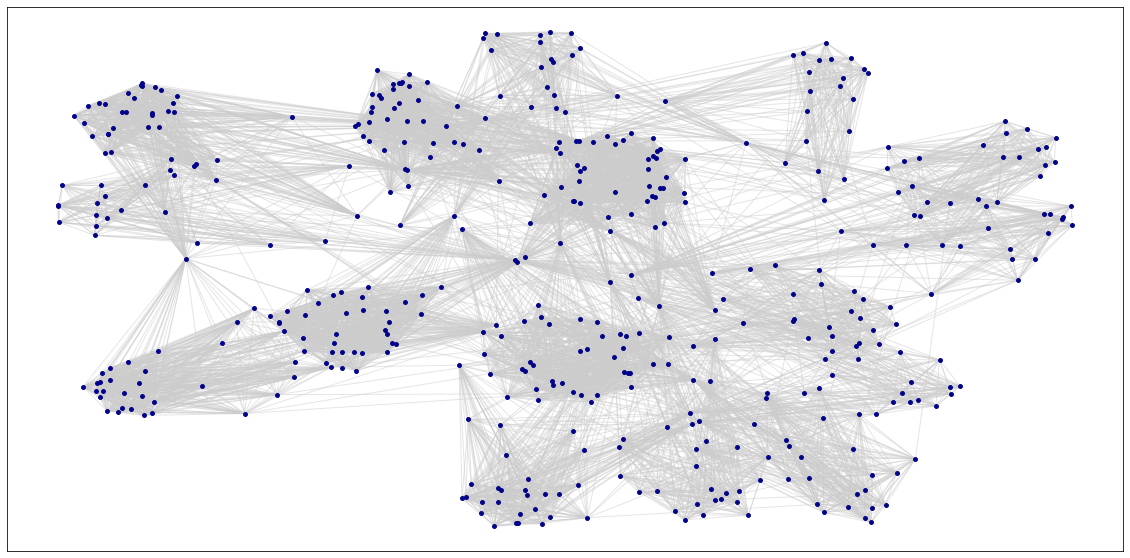

In [14]:
%matplotlib inline

figure = plt.figure(figsize=(20.0,10.0))
plot = figure.add_subplot(111)

layout = nx.spring_layout(actor_graph_k_core, iterations=10)

nx.draw_networkx_edges(actor_graph_k_core,
                       layout, 
                       width=1,
                       alpha=0.5,
                       edge_color="#cccccc",
                       ax=plot)

nx.draw_networkx_nodes(actor_graph_k_core,
                       layout,
                       nodelist=actor_graph_k_core.nodes,
                       node_color='darkblue',
                       node_size=15,
                       ax=plot)

# Find The Kevin Bacon(s)

We’re going to find the Kevin Bacons.

We’ll refer to the maximum number of hops a cast member needs to reach all other cast members as the “Kevin Bacon distance”.

The Kevin Bacons are the cast members who have the smallest Kevin Bacon distance.

To find the Kevin Bacons, we’ll first have to find all the connected components (since we don’t exactly have a Kevin Bacon if our graph is disconnected).

In [15]:
cc_node_label_mapping_wrapped = r.algos.clustering.connected_components(actor_graph_wrapped)
cc_node_label_mapping = cc_node_label_mapping_wrapped.value
label_counts = Counter()
for _, label in cc_node_label_mapping.items():
    label_counts[label] += 1

In [16]:
label_counts

Counter({0: 7833,
         1: 10,
         2: 1,
         3: 1,
         4: 10,
         5: 1,
         6: 1,
         7: 1,
         8: 2,
         9: 10,
         10: 3,
         11: 1,
         12: 1,
         13: 10,
         14: 1,
         15: 1,
         16: 1,
         17: 10,
         18: 12,
         19: 1,
         20: 1,
         21: 18,
         22: 8,
         23: 1,
         24: 1,
         25: 1,
         26: 11,
         27: 1,
         28: 1,
         29: 1,
         30: 17,
         31: 10,
         32: 1,
         33: 1,
         34: 1,
         35: 10,
         36: 1,
         37: 1,
         38: 1,
         39: 1,
         40: 1,
         41: 5,
         42: 3,
         43: 4,
         44: 3,
         45: 7,
         46: 12,
         47: 2,
         48: 1,
         49: 1,
         50: 1,
         51: 1,
         52: 1,
         53: 1,
         54: 2,
         55: 7,
         56: 1,
         57: 11,
         58: 5,
         59: 1,
         60: 1,
         61: 1,
  

We have multiple connected components. We will find the Kevin Bacon of the largest connected component since that one has more edges between actors.

In [17]:
largest_cc_label, _ = max(label_counts.items(), key = lambda pair: pair[1])
largest_cc_node_set = {node for node, label in cc_node_label_mapping.items() if label == largest_cc_label}
largest_cc_node_set_wrapped = r.wrappers.NodeSet.PythonNodeSet(largest_cc_node_set)
largest_cc_subgraph_wrapped = r.algos.subgraph.extract_edgeset(actor_graph_wrapped, largest_cc_node_set_wrapped)
largest_cc_subgraph_wrapped = r.translate(largest_cc_subgraph_wrapped, r.wrappers.EdgeSet.ScipyEdgeSet)

We now need to find each actor’s Kevin Bacon distance.

One of the benefits of using metagraph is that when we are not forced to use metagraph end-to-end since metagraph supports algorithms on graph with various internal representations.

We can take out graph easily out of metagraph and use whatever graph library we desire because of metagraph’s translation capabilities.

We’ll demonstrate how to take our NetworkX graph, convert it into a SciPy adjacency matrix, and run SciPy’s implementation of Dijkstra on it.

In [18]:
%time distance_matrix = ss.csgraph.dijkstra(largest_cc_subgraph_wrapped.value)

CPU times: user 55.1 s, sys: 175 ms, total: 55.3 s
Wall time: 55.2 s


Once we have all the Kevin Bacon distances from every cast member, we can find the smallest Kevin Bacon distance. 

In [19]:
kevin_bacon_dists = distance_matrix.max(axis=0)
min_kevin_bacon_dist = kevin_bacon_dists.min()
min_kevin_bacon_dist

6.0

From here, we can determine the Kevin Bacon(s)!

In [20]:
kevin_bacon_indices = np.where(kevin_bacon_dists==min_kevin_bacon_dist)[0]
kevin_bacons = sorted([largest_cc_subgraph_wrapped.node_list[kevin_bacon_index] 
                       for kevin_bacon_index in kevin_bacon_indices])

In [21]:
len(kevin_bacons)

295

In [22]:
for kevin_bacon in sorted(kevin_bacons):
    print(kevin_bacon)

50 Cent
Aasif Mandvi
Adam Pally
Adam Scott
Alec Baldwin
Alexis Bledel
Alfred Molina
Alison Pill
Amanda Plummer
America Ferrera
Andrew Bachelor
Andy Richter
Andy Samberg
Angelique Cabral
Anna Faris
Anna Kendrick
Anthony Anderson
Anthony Hopkins
Anthony Mackie
Beau Bridges
Ben Kingsley
Benicio Del Toro
Bill Murray
Billy Connolly
Bob Odenkirk
Bobby Cannavale
Bradley Cooper
Brandon Routh
Brian Tyree Henry
Brie Larson
Brittany Murphy
Brooke D'Orsay
Brooklyn Decker
Bruce Willis
Busy Philipps
Cameron Diaz
Cate Blanchett
Cathy Cliften
Celia Weston
Charlie Murphy
Charlie Sheen
Chelcie Ross
Chloë Grace Moretz
Chris Parnell
Chris Pratt
Christina Hendricks
Christina Ricci
Christopher McDonald
Christopher Mintz-Plasse
Christopher Plummer
Christopher Walken
Clive Owen
Cole Hauser
Common
Constance Wu
Danai Gurira
Danny Trejo
David Koechner
Dax Shepard
Demi Moore
Dennis Quaid
Dermot Mulroney
Devon Aoki
Diane Keaton
Djimon Hounsou
Don Cheadle
Donal Logue
Donald Faison
Dwayne Johnson
Elijah Wood
Elizabe

It turns out that the Netflix world is much more connected than the whole Hollywood film industry since there are so many cast members who are well-connected.